In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.benchmark as benchmark
import torch._dynamo
from torchinfo import summary
import seaborn as sns
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch


In [56]:
torch._dynamo.config.cache_size_limit = 16

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [57]:
df = sns.load_dataset('diamonds')
df = df[['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut']]

df['cut'] = (df['cut'] == 'Ideal').astype(int)

X = df.drop('cut', axis=1)
y = df['cut']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

print(X.shape)
print(y.shape)

ideal_percentage = df['cut'].mean() * 100
print(f"Percentage of diamonds with 'Ideal' cut: {ideal_percentage:.2f}%")

model = LogisticRegression(penalty='l2', C=0.001, max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_proba = model.predict_proba(X_test)
loss = log_loss(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Ideal', 'Ideal']))
print(model.coef_)
print(f"Log Loss: {loss:.6f}")

(53940, 7)
(53940,)
Percentage of diamonds with 'Ideal' cut: 39.95%
Test Accuracy: 79.30%
Classification Report:
              precision    recall  f1-score   support

   Not Ideal       0.82      0.85      0.83      6496
       Ideal       0.75      0.71      0.73      4292

    accuracy                           0.79     10788
   macro avg       0.79      0.78      0.78     10788
weighted avg       0.79      0.79      0.79     10788

[[-0.15688782 -0.46189194 -1.57368125  0.22509094 -0.08309788 -0.03167662
  -0.08671039]]
Log Loss: 0.451068


/Users/nhatt/Downloads/All_Mac/Code/ML_experiments/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/nhatt/Downloads/All_Mac/Code/ML_experiments/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/nhatt/Downloads/All_Mac/Code/ML_experiments/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/nhatt/Downloads/All_Mac/Code/ML_experiments/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nhatt/Downloads/All_Mac/Code/ML_experiments/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered

In [58]:
def train(model, criterion, optimizer):
    print(summary(model, input_data=X_train_tensor))

    torch.set_printoptions(threshold=float('inf'))
    for name, param in model.named_parameters():
        print(name)
        print(param)

    @torch._dynamo.explain
    def run_model(x):
        return model(x)

    run_model(X_train_tensor) # type: ignore

    epochs = 10000
    best_test_loss = float('inf')

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        train_outputs = model(X_train_tensor)
        train_loss = criterion(train_outputs, y_train_tensor)
        train_loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_predictions = torch.argmax(test_outputs, dim=1)
            test_accuracy = (test_predictions == y_test_tensor).sum().item() / y_test_tensor.size(0)

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        if test_loss.item() < best_test_loss:
            best_test_loss = test_loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.8f}, Test Loss: {test_loss.item():.8f}, Test Accuracy: {test_accuracy:.4f}")

    print()
    print(f"Lowest Test Loss: {best_test_loss:.8f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [59]:
class DiamondNN(nn.Module):
    def __init__(self, n, num_layers=1):
        super().__init__()
        self.bias = torch.nn.Parameter(torch.zeros(n))

        self.bns = nn.ModuleList()
        self.linears = nn.ModuleList()
        for i in range(num_layers):
            dim = n * (2**i)
            self.bns.append(nn.BatchNorm1d(dim * 2, affine=False))
            self.linears.append(nn.Linear(dim * 2, dim))

            with torch.no_grad():
                self.linears[i].weight.copy_(torch.eye(dim).repeat_interleave(2, dim=1)) # type: ignore
                nn.init.zeros_(self.linears[i].bias)                                     # type: ignore

        self.final_bn = nn.BatchNorm1d(2 * n * (2**num_layers), affine=False)
        self.final = nn.Linear((2 * n) * (2**num_layers), 1)

        with torch.no_grad():
            nn.init.zeros_(self.final.weight)
            nn.init.zeros_(self.final.bias)

    def forward(self, x):
        x = x + self.bias
        pos = F.relu(x)
        neg = -F.relu(-x)
        x = torch.cat([pos, neg], dim=-1)

        for linear, bn in zip(self.linears, self.bns):
            out = linear(bn(x))
            pos = F.relu(out)
            neg = -F.relu(-out)
            x = torch.cat([x, pos, neg], dim=-1)

        x = self.final(self.final_bn(x))
        return torch.cat([x, -x], dim=-1)

In [60]:
class CustomActivationEfficient(nn.Module):
    def __init__(self, num_features, num_control_points=1000, eps=1e-6):
        super(CustomActivationEfficient, self).__init__()
        self.register_buffer("mins", None)
        self.register_buffer("maxs", None)

        self.eps = eps
        self.num_control_points = num_control_points

        self.r_weight = nn.Parameter(torch.zeros(num_features, num_control_points))  # (num_features, num_control_points)
        self.l_weight = nn.Parameter(torch.zeros(num_features, num_control_points))  # (num_features, num_control_points)

        self.register_buffer("local_bias", torch.arange(num_control_points))  # (num_control_points,)
        self.register_buffer("feature_offset", torch.arange(num_features).view(1, -1) * self.num_control_points)  # (1, num_features)

    def forward(self, x):
        # x: (batch_size, num_features)

        if self.training or self.mins is None or self.maxs is None:
            self.mins = x.amin(dim=0, keepdim=True)  # (1, num_features)
            self.maxs = x.amax(dim=0, keepdim=True)  # (1, num_features)

        x = (x - self.mins) / (self.maxs - self.mins + self.eps) * (self.num_control_points - 1)  # (batch_size, num_features)

        # TODO: may change to feature-major order (num_features, batch_size) since that may help with memory access patterns (improved locality)
        
        lower_indices_float = x.floor().clamp(0, self.num_control_points - 2)  # (batch_size, num_features)
        lower_indices = lower_indices_float.long() + self.feature_offset  # (batch_size, num_features)

        indices = torch.stack((lower_indices, lower_indices + 1), dim=-1)  # (batch_size, num_features, 2)
        vals = F.embedding(indices, self.get_interp_tensor())  # (batch_size, num_features, 2, 1)

        lower_val, upper_val = vals.squeeze(-1).unbind(-1)  # each: (batch_size, num_features)
        # print((torch.lerp(lower_val, upper_val, x - lower_indices_float)).sum(dim=-1).shape)
        x = (torch.lerp(lower_val, upper_val, x - lower_indices_float)).sum(dim=-1).unsqueeze(-1)  # (batch_size, 1)
        return x
        # return torch.cat([x, -x], dim=-1)  # (batch_size, 2)
    
    def get_interp_tensor(self):
        cs_r_weight = torch.cumsum(self.r_weight, dim=1)  # (num_features, num_control_points)
        cs_l_weight = torch.cumsum(self.l_weight, dim=1)  # (num_features, num_control_points)

        cs_r_weight_bias_prod = torch.cumsum(self.r_weight * self.local_bias, dim=1)  # type: ignore (num_features, num_control_points)
        cs_l_weight_bias_prod = torch.cumsum(self.l_weight * self.local_bias, dim=1)  # type: ignore (num_features, num_control_points)

        r_interp = (self.local_bias * cs_r_weight - cs_r_weight_bias_prod)  # type: ignore (num_features, num_control_points)
        l_interp = (cs_l_weight_bias_prod[..., -1:] - cs_l_weight_bias_prod) - self.local_bias * (cs_l_weight[..., -1:] - cs_l_weight)  # type: ignore (num_features, num_control_points)
        return (r_interp + l_interp).view(-1, 1)  # (num_features * num_control_points, 1)

In [61]:
class DiamondNN(nn.Module):
    def __init__(self, n, num_layers=1):
        super().__init__()
        self.custom_activation = CustomActivationEfficient(num_features=n, num_control_points=10)
        self.custom_activation2 = CustomActivationEfficient(num_features=1, num_control_points=10)

        with torch.no_grad():
            self.custom_activation.r_weight[:, 0] = 1.0
            self.custom_activation2.r_weight[:, 0] = 0.0

    def forward(self, x):
        x = self.custom_activation(x)
        x = self.custom_activation2(x)
        return torch.cat([x, -x], dim=-1)  # (batch_size, 2)

In [66]:
import torch, torch.nn.functional as F, time

# dummy sizes roughly matching your real ones
B, Ftr, C = 1024, 512, 1000
weight = torch.randn(Ftr*C, 1, device='mps')
feat_offset = (torch.arange(Ftr, device='mps') * C).view(1, -1)
x = torch.rand(B, Ftr, device='mps') * (C-1)

def one_call():
    li  = x.floor().clamp(0, C-2).long() + feat_offset
    idx = torch.stack((li, li+1), -1)
    F.embedding(idx, weight).sum().backward()

def two_calls():
    li  = x.floor().clamp(0, C-2).long() + feat_offset
    F.embedding(li, weight).sum().backward()
    F.embedding(li+1, weight).sum().backward()

for fn in (one_call, two_calls):
    # torch.cuda.synchronize(); t0 = time.time()
    t0 = time.time()
    for _ in range(100): fn()
    # torch.cuda.synchronize()
    print(fn.__name__, time.time()-t0)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class TwoEmbeddings(nn.Module):
    def __init__(self, num_features, num_control_points=1000):
        super().__init__()
        self.num_features = num_features
        self.num_control_points = num_control_points
        # weights for interpolation table
        self.r_weight = nn.Parameter(torch.randn(num_features, num_control_points))
        self.l_weight = nn.Parameter(torch.randn(num_features, num_control_points))
        self.local_bias = torch.arange(num_control_points)
        self.feature_offset = (torch.arange(num_features) * num_control_points).view(1, -1)

    def get_interp_tensor(self):
        cs_r = torch.cumsum(self.r_weight, dim=1)
        cs_l = torch.cumsum(self.l_weight, dim=1)
        cs_r_bp = torch.cumsum(self.r_weight * self.local_bias, dim=1)
        cs_l_bp = torch.cumsum(self.l_weight * self.local_bias, dim=1)
        r_interp = (self.local_bias * cs_r - cs_r_bp)
        l_interp = (cs_l_bp[..., -1:] - cs_l_bp) - self.local_bias * (cs_l[..., -1:] - cs_l)
        return (r_interp + l_interp).view(-1, 1)

    def forward(self, x):
        B, F = x.shape
        # normalize to [0, C-1]
        x_norm = (x - x.min(dim=0)[0]) / (x.max(dim=0)[0] - x.min(dim=0)[0] + 1e-6) * (self.num_control_points - 1)
        lower = x_norm.floor().clamp(0, self.num_control_points - 2)
        lower_long = lower.long()
        flat_interp = self.get_interp_tensor()
        low = F.embedding(lower_long + self.feature_offset.to(x.device), flat_interp).squeeze(-1)
        high = F.embedding(lower_long + 1 + self.feature_offset.to(x.device), flat_interp).squeeze(-1)
        return torch.lerp(low, high, (x_norm - lower))

class SingleEmbeddingWithBuffer(nn.Module):
    def __init__(self, num_features, num_control_points=1000):
        super().__init__()
        self.num_features = num_features
        self.num_control_points = num_control_points
        self.r_weight = nn.Parameter(torch.randn(num_features, num_control_points))
        self.l_weight = nn.Parameter(torch.randn(num_features, num_control_points))
        self.local_bias = torch.arange(num_control_points)
        self.feature_offset = (torch.arange(num_features) * num_control_points).view(1, -1)
        self.register_buffer('_idx_buf', None)

    def get_interp_tensor(self):
        cs_r = torch.cumsum(self.r_weight, dim=1)
        cs_l = torch.cumsum(self.l_weight, dim=1)
        cs_r_bp = torch.cumsum(self.r_weight * self.local_bias, dim=1)
        cs_l_bp = torch.cumsum(self.l_weight * self.local_bias, dim=1)
        r_interp = (self.local_bias * cs_r - cs_r_bp)
        l_interp = (cs_l_bp[..., -1:] - cs_l_bp) - self.local_bias * (cs_l[..., -1:] - cs_l)
        return (r_interp + l_interp).view(-1, 1)

    def forward(self, x):
        B, F = x.shape
        x_norm = (x - x.min(dim=0)[0]) / (x.max(dim=0)[0] - x.min(dim=0)[0] + 1e-6) * (self.num_control_points - 1)
        lower = x_norm.floor().clamp(0, self.num_control_points - 2).long()
        low = lower
        high = lower + 1

        # allocate/grow buffer
        if self._idx_buf is None or self._idx_buf.size(0) < B:
            self._idx_buf = torch.empty(B, F, 2, dtype=torch.long, device=x.device)
        idx = self._idx_buf[:B]
        idx[..., 0].copy_(low + self.feature_offset.to(x.device))
        idx[..., 1].copy_(high + self.feature_offset.to(x.device))

        interp = self.get_interp_tensor()
        vals = F.embedding(idx, interp).squeeze(-1)
        lo, hi = vals.unbind(-1)
        return torch.lerp(lo, hi, (x_norm - lower.float()))

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
B, F = 512, 1024
x = torch.randn(B, F, device=device)

m1 = TwoEmbeddings(F).to(device)
m2 = SingleEmbeddingWithBuffer(F).to(device)

# Warm-up
for _ in range(10):
    _ = m1(x)
    _ = m2(x)

# Measure
def measure(module, x, niter=100):
    times = []
    for _ in range(niter):
        if device.type == 'cuda':
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            _ = module(x)
            end.record()
            torch.cuda.synchronize()
            times.append(start.elapsed_time(end))
        else:
            t0 = time.time()
            _ = module(x)
            t1 = time.time()
            times.append((t1-t0)*1000)
    return sum(times)/len(times)

t1 = measure(m1, x)
t2 = measure(m2, x)

print(f"Avg time Two Embeddings: {t1:.3f} ms")
print(f"Avg time Single Embedding with Buffer: {t2:.3f} ms")



AttributeError: 'int' object has no attribute 'embedding'

In [62]:
model = torch.compile(DiamondNN(n=X.shape[1], num_layers=1), backend="aot_eager").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001 * 1e-2, weight_decay=0.0)

In [54]:
train(model, criterion, optimizer)

Layer (type:depth-idx)                        Output Shape              Param #
OptimizedModule                               [43152, 4]                --
├─DiamondNN: 1-1                              [43152, 4]                --
│    └─CustomActivationEfficient: 2-1         [43152, 2]                140
│    └─CustomActivationEfficient: 2-2         [43152, 2]                20
Total params: 160
Trainable params: 160
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 13.81
Input size (MB): 1.21
Forward/backward pass size (MB): 1.38
Params size (MB): 0.00
Estimated Total Size (MB): 2.59
_orig_mod.custom_activation.r_weight
Parameter containing:
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.,

KeyboardInterrupt: 

In [22]:
for name, param in model.named_parameters():
    print(name)
    print(param)

_orig_mod.r_weight
Parameter containing:
tensor([[ 3.0079e-03,  3.7879e-03,  7.3635e-03,  4.7249e-03,  1.8568e-03,
          1.6683e-04, -1.7829e-03,  4.5856e-03,  7.5702e-03,  6.1583e-03,
          2.0628e-03,  4.5353e-03,  4.0805e-03,  2.4133e-04, -1.4228e-02,
         -2.1825e-02, -2.2614e-02, -8.8414e-03,  1.4040e-02,  1.4505e-02,
          1.2919e-02,  8.7071e-03,  1.0730e-02,  4.8258e-03, -2.5706e-03,
         -1.6391e-02, -2.9359e-02, -3.0317e-02,  1.3116e-02,  2.6551e-02,
          2.1889e-02,  5.2548e-03, -6.8615e-03, -1.5912e-02, -2.5445e-02,
         -3.1011e-02, -2.8944e-02, -2.2584e-02,  7.3355e-03,  1.7511e-02,
          1.6697e-02,  2.9045e-02,  2.2402e-02,  6.6605e-04, -3.5080e-02,
         -3.5155e-02, -4.5240e-02, -5.8682e-02, -5.8420e-02, -3.6776e-02,
          2.2878e-02, -7.6820e-03,  1.8401e-02,  1.3976e-02,  1.6049e-02,
          1.8839e-02,  2.1579e-02,  2.3785e-02,  3.5762e-02, -1.1775e-02,
          7.2577e-03,  3.7076e-02,  5.3825e-02,  4.2173e-02,  4.1883e-0

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 2]                --
├─CustomActivationEfficient: 1-1         [43152, 2]                1,400
Total params: 1,400
Trainable params: 1,400
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 120.83
Input size (MB): 1.21
Forward/backward pass size (MB): 0.69
Params size (MB): 0.01
Estimated Total Size (MB): 1.90
_orig_mod.r_weight
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

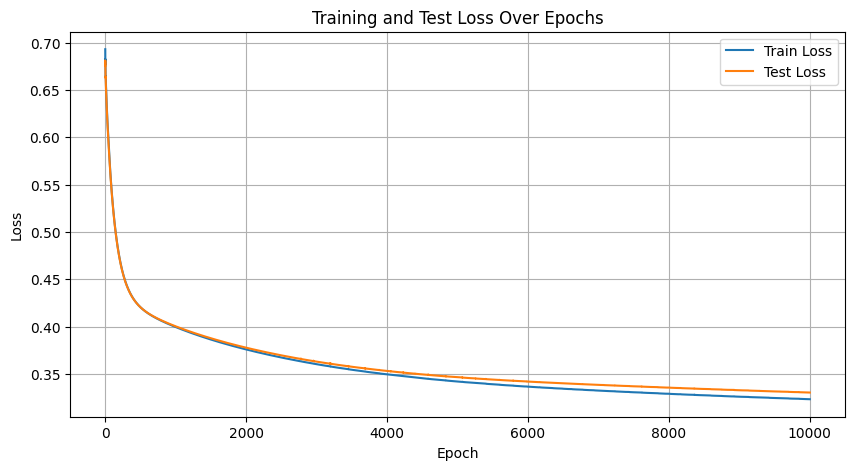

In [21]:
train(model, criterion, optimizer)

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 2]                --
├─DiamondNN: 1-1                         [43152, 2]                7
│    └─ModuleList: 2-1                   --                        --
│    │    └─BatchNorm1d: 3-1             [43152, 14]               --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Linear: 3-2                  [43152, 7]                105
│    └─BatchNorm1d: 2-3                  [43152, 28]               --
│    └─Linear: 2-4                       [43152, 1]                29
Total params: 141
Trainable params: 141
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 5.78
Input size (MB): 1.21
Forward/backward pass size (MB): 2.76
Params size (MB): 0.00
Estimated Total Size (MB): 3.97
_orig_mod.bias
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
_orig_mod.linears.0.weight
Parameter containing:
ten

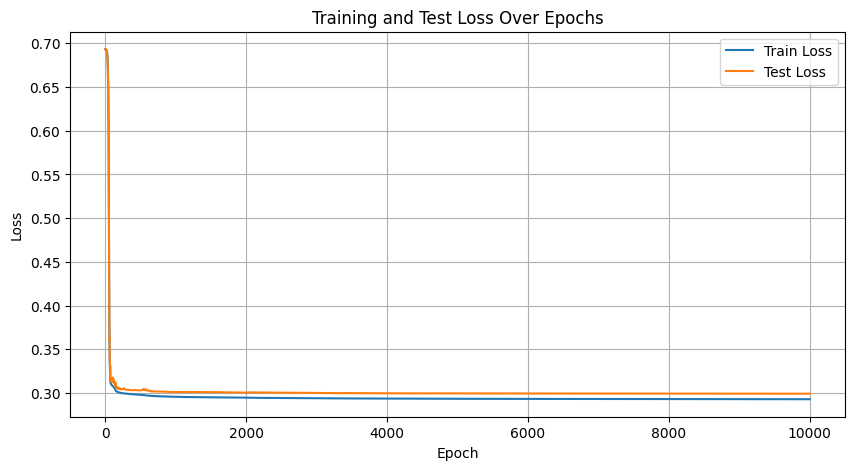

In [58]:
train(model, criterion, optimizer)

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 2]                --
├─DiamondNN: 1-1                         [43152, 2]                7
│    └─ModuleList: 2-5                   --                        --
│    │    └─BatchNorm1d: 3-1             [43152, 14]               --
│    └─ModuleList: 2-6                   --                        (recursive)
│    │    └─Linear: 3-2                  [43152, 7]                105
│    └─ModuleList: 2-5                   --                        --
│    │    └─BatchNorm1d: 3-3             [43152, 28]               --
│    └─ModuleList: 2-6                   --                        (recursive)
│    │    └─Linear: 3-4                  [43152, 14]               406
│    └─ModuleList: 2-5                   --                        --
│    │    └─BatchNorm1d: 3-5             [43152, 56]               --
│    └─ModuleList: 2-6                   --                       

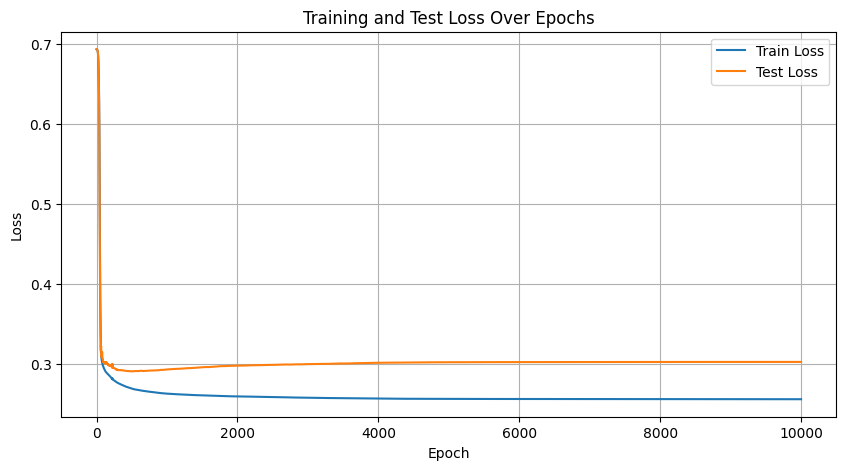

In [32]:
train(model, criterion, optimizer)

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 2]                --
├─DiamondNN: 1-1                         [43152, 2]                34,091
Total params: 34,091
Trainable params: 34,091
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.21
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 1.21
_orig_mod.bias
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
_orig_mod.linears.0.weight
Parameter containing:
tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0.,

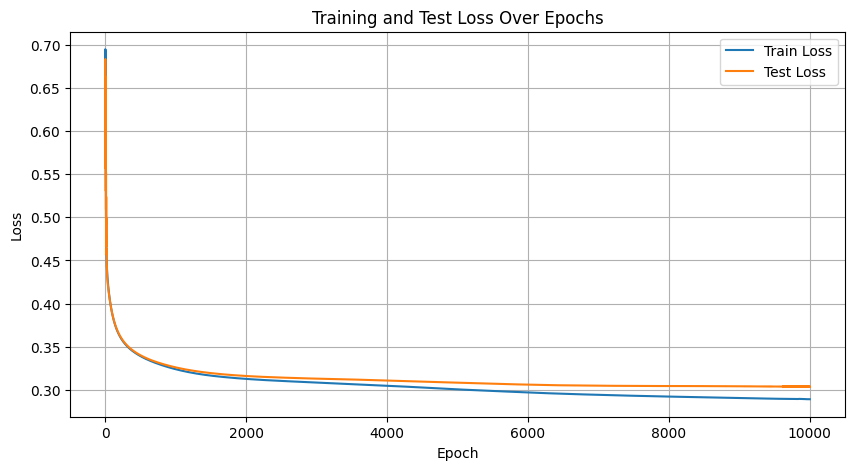

In [24]:
train(model, criterion, optimizer)

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 2]                --
├─DiamondNN: 1-1                         [43152, 2]                7
│    └─ModuleList: 2-5                   --                        --
│    │    └─BatchNorm1d: 3-1             [43152, 14]               --
│    └─ModuleList: 2-6                   --                        (recursive)
│    │    └─Linear: 3-2                  [43152, 7]                105
│    └─ModuleList: 2-5                   --                        --
│    │    └─BatchNorm1d: 3-3             [43152, 28]               --
│    └─ModuleList: 2-6                   --                        (recursive)
│    │    └─Linear: 3-4                  [43152, 14]               406
│    └─ModuleList: 2-5                   --                        --
│    │    └─BatchNorm1d: 3-5             [43152, 56]               --
│    └─ModuleList: 2-6                   --                       

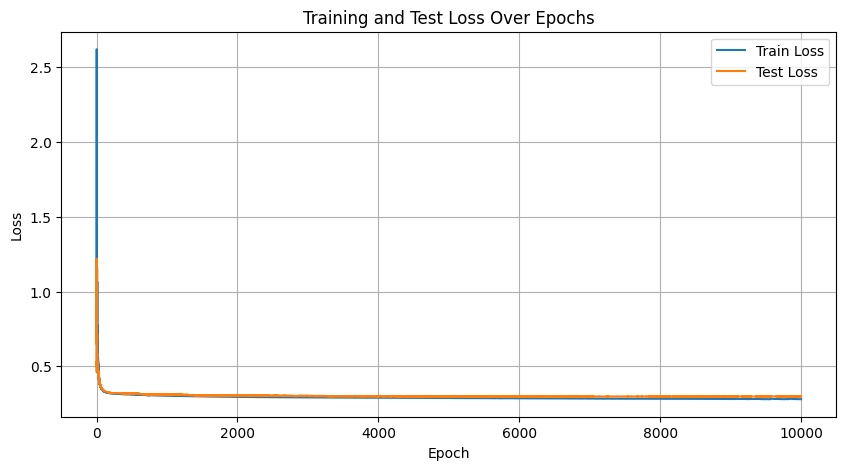

In [19]:
train(model, criterion, optimizer)

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 2]                --
├─DiamondNN: 1-1                         [43152, 2]                2,227
Total params: 2,227
Trainable params: 2,227
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.21
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 1.21
_orig_mod.bias
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
_orig_mod.linears.0.weight
Parameter containing:
tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0.

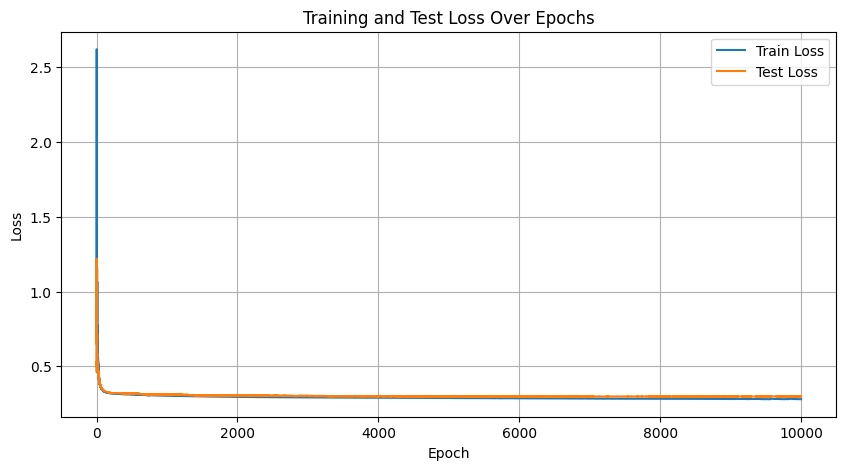

In [16]:
train(model, criterion, optimizer)